In [1]:

# Author: Shilin Zhang
# Created Date: 13 June 2022

# Description:
# Replication work of the paper: 
# Optimal selection of time lags for TDSEP based on genetic algorithm

# Related Paper:
# TDSEP - an efficient algorithm for blind separation using time structure

# Method of determning the optimal lag: 
# Indenpendent Component Analysis (ICA)
# Genetic Algorithm (GA)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import yfinance as yf
from numpy.random import randint
from numpy.random import rand

In [3]:
# read the data from yahoo finance

startdate_training = '2012-04-01'
# enddate_training = '2014-05-01' # short dataset for testing

enddate_training = '2020-05-01'
startdate_testing = '2020-05-01'
enddate_testing = '2022-06-01'
datasource = 'SPY'
data = yf.download(datasource,start = startdate_training,end = enddate_training)

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-02,140.639999,142.210007,140.360001,141.839996,116.762009,151741100
2012-04-03,141.639999,141.880005,140.429993,141.259995,116.284531,155806700
2012-04-04,140.220001,140.339996,139.339996,139.860001,115.132072,146896000
2012-04-05,139.380005,140.199997,139.259995,139.789993,115.074417,137439400
2012-04-09,138.029999,139.839996,137.839996,138.220001,113.782043,127555900
...,...,...,...,...,...,...
2020-04-24,280.730011,283.700012,278.500000,282.970001,273.704010,85063200
2020-04-27,285.119995,288.269989,284.619995,287.049988,277.650452,77896600
2020-04-28,291.019989,291.399994,285.399994,285.730011,276.373688,105270000


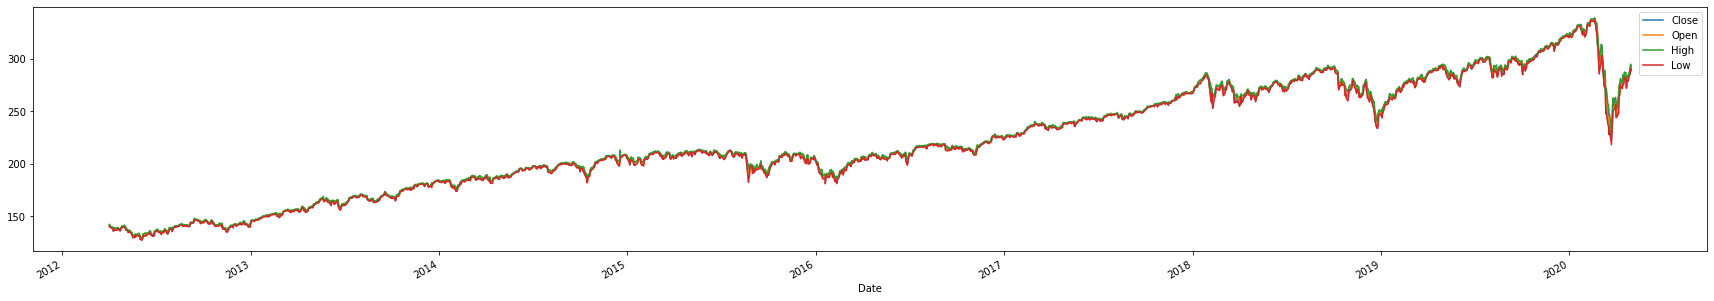

In [5]:
data.plot(y = ['Close','Open','High','Low'], kind = 'line',figsize=(30,5))
plot.show()

In [6]:
# Showing that there is a data leakage in stock price dataset

data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999662,0.999617,0.999442,0.998220,-0.382798
High,0.999662,1.000000,0.999207,0.999555,0.998749,-0.370167
Low,0.999617,0.999207,1.000000,0.999609,0.997955,-0.398896
Close,0.999442,0.999555,0.999609,1.000000,0.998733,-0.387055
Adj Close,0.998220,0.998749,0.997955,0.998733,1.000000,-0.372172
Volume,-0.382798,-0.370167,-0.398896,-0.387055,-0.372172,1.000000


In [7]:
def data_shift(data,target):
    data_shifted = data.drop([target],axis=1).shift()
    data_preprocessed = pd.concat([data_shifted,data[target]], axis=1)
    data_preprocessed.dropna(inplace=True)
    return data_preprocessed

In [8]:
data_preprocessed = data_shift(data,'Close')
data_preprocessed

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2012-04-03,140.639999,142.210007,140.360001,116.762009,151741100.0,141.259995
2012-04-04,141.639999,141.880005,140.429993,116.284531,155806700.0,139.860001
2012-04-05,140.220001,140.339996,139.339996,115.132072,146896000.0,139.789993
2012-04-09,139.380005,140.199997,139.259995,115.074417,137439400.0,138.220001
2012-04-10,138.029999,139.839996,137.839996,113.782043,127555900.0,135.899994
...,...,...,...,...,...,...
2020-04-24,280.489990,283.940002,278.750000,269.941406,104709700.0,282.970001
2020-04-27,280.730011,283.700012,278.500000,273.704010,85063200.0,287.049988
2020-04-28,285.119995,288.269989,284.619995,277.650452,77896600.0,285.730011


In [9]:
# Showing that there still exists high correlation between feature lagged values

data_preprocessed.corr()

,Open,High,Low,Adj Close,Volume,Close
Open,1.000000,0.999661,0.999617,0.998221,-0.383218,0.998417
High,0.999661,1.000000,0.999207,0.998750,-0.370582,0.998487
Low,0.999617,0.999207,1.000000,0.997957,-0.399311,0.998618
Adj Close,0.998221,0.998750,0.997957,1.000000,-0.372630,0.997669
Volume,-0.383218,-0.370582,-0.399311,-0.372630,1.000000,-0.387256
Close,0.998417,0.998487,0.998618,0.997669,-0.387256,1.000000


In [10]:
# observations matrix X
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
X = mmscaler.fit_transform(data_preprocessed).T

In [11]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered

# calculate the covariance matrix of six observed time series
# def covariance(x):
#     mean = np.mean(x, axis=1, keepdims=True)
#     n = np.shape(x)[1] - 1
#     m = x - mean

#     return (m.dot(m.T))/n

In [12]:
# Materials related to whitening transformation

# https://learndataa.com/2020/09/15/data-preprocessing-whitening-or-sphering-in-python/
    
def whiten(X):
    # Calculate the covariance matrix using PCA
    covarMatrix = np.cov(X)

    # Single value decomposition
    V, S, U = np.linalg.svd(covarMatrix)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM =  np.dot(d, V.T)

    # Project onto whitening matrix
    Z = np.dot(whiteM, X)

    return Z, whiteM

In [13]:
X_center = center(X)

In [14]:
Z,whiteM = whiten(X_center)

In [15]:
print(np.round(np.cov(Z)))

[[ 1.  0.  0. -0. -0.  0.]
 [ 0.  1.  0. -0.  0. -0.]
 [ 0.  0.  1. -0. -0.  0.]
 [-0. -0. -0.  1.  0. -0.]
 [-0.  0. -0.  0.  1.  0.]
 [ 0. -0.  0. -0.  0.  1.]]


In [16]:
Z.shape

(6, 2032)

In [17]:
# Calculate Rotation Matrix Q
from scipy.linalg import eig

# covariance matrix of Z with tau  = Q_T * covariance matrix of S with tau * Q
# TDSEP - an efficient algorithm for blind separation using time structure

# Calculate the average covariance matrix with a list of lags

def covarMatrix_with_lags(x,lags):
    m,n = x.shape
    matrix = np.empty((m,m), float)
    for i in lags:
        x1 = x[:,i:n]
        x2 = x[:,0:n-i]
        mean1 = np.mean(x1, axis=1, keepdims=True)
        mean2 = np.mean(x2, axis=1, keepdims=True)
        num = np.shape(x1)[1] - 1
        m1 = x1 - mean1
        m2 = x2 - mean2
        covarMatrix = m1.dot(m2.T)/num
        matrix = matrix +  covarMatrix
    return matrix/len(lags)

# Compute the orthogonal matrix Q via approximate simultaneous diagonalization

# def generate_Q(Z,lags):
#     lambda_Z = covarMatrix_with_lags(Z,lags)
#     eigs,w = eig(lambda_Z)
#     Q = np.real(w.T)
#     return Q

def generate_Q(Z,lags):
    
    lambda_Z = covarMatrix_with_lags(Z,lags)
    vals, vecs = eig(lambda_Z)
    Q = np.real(vecs.T)

#     Q = np.array([[1,0,0,0,0,0],
#      [0,1,0,0,0,0],
#      [0,0,1,0,0,0],
#      [0,0,0,1,0,0],
#      [0,0,0,0,1,0],
#      [0,0,0,0,0,1]])

    return Q

In [19]:
# lambda_Z = covarMatrix_with_lags(Z,[2,3,8])

# lambda_Z

In [20]:
#Test the generate_Q function

# Q = generate_Q(Z,[2,3,5])
# Y = Q @ Z
# np.round(np.cov(Y))

In [21]:
# print(np.linalg.det(np.round(np.cov(Y))))
# print(np.linalg.det(np.cov(Y)))

In [18]:
# Negentropy Estimation

# One of the estimation function G1 
def G(x):
    return 1/a_1 * np.cosh(a_1 * x)

def J(Y):
    row,col = Y.shape
    J = 0
    for i in range(0,row):
        sum1 = 0
        sum2 = 0
        for j in range(0,col):
            sum1 = sum1 + G(Y[i][j])
            v = np.random.normal(0,1)
            sum2 = sum2 +  G(v)
        J = J + ((sum1 - sum2)/col) ** 2
    return J

In [29]:
# Genetic algorithm search for optimization problem

# Transfer bitstring of integer values to lag list
def gene2lags(best):
    table = pd.DataFrame(best,columns = ['lag'])
    best_lag_list = []
    for i in range(0,n_d):
        if table.iloc[i][0] == 1:
            best_lag_list.append(n_d - (i+1))
    return best_lag_list

# objective function
def obj(x):
#     lags = x
    lags = gene2lags(x)
    Q = generate_Q(Z,lags)
    Y = Q @ Z
#     result  =  n_d * J(Y)/sum(x)
    result  =  J(Y)/(sum(x) * n_d )
    return -result

# selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]

In [20]:
# Genetic algorithm

def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, objective(pop[0])
    # enumerate generations
    for gen in range(n_iter):
#         print('Iteration: %d'%(gen + 1))
        # evaluate all candidates in the population
        scores = [objective(c) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                # print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
                print("iteration: %d, number of lags: %d, score: %.3f" %(gen + 1, sum(pop[i]), scores[i]))
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]

In [21]:
# Parameter Setting

# length of an individual/ maximum tau
n_d = 40
# number of generation
n_g = 500
# number of population
n_p = 100
# crossover prob
p_c = 0.85
# mutation prob
p_m = 0.05

# parameter for negentropy estimation
a_1 = 1.5

In [30]:
best, score = genetic_algorithm(obj, n_d, n_g, n_p, p_c, p_m)
print('Done!')
print('f(%s) = %f' % (best, score))

iteration: 1, number of lags: 21, score: -6126.649
iteration: 1, number of lags: 26, score: -10631.797
iteration: 1, number of lags: 15, score: -12550.275
iteration: 1, number of lags: 21, score: -15275.078
iteration: 1, number of lags: 15, score: -74867.791
iteration: 1, number of lags: 13, score: -168357.960
iteration: 6, number of lags: 14, score: -190725.233
iteration: 10, number of lags: 15, score: -297096.199
iteration: 10, number of lags: 13, score: -562417.356
iteration: 55, number of lags: 12, score: -642443.549
iteration: 61, number of lags: 9, score: -792825.663
Done!
f([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]) = -792825.663022


In [43]:
# best1 = best
# print(best1)
# sum(best1)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


7

In [45]:
# best2 = best
# print(best2)
# sum(best2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


2

In [47]:
# best3 = best
# print(best3)
# sum(best3)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


4

In [49]:
# best4 = best
# print(best4)
# sum(best4)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


10

In [51]:
# best5 = best
# print(best5)
# sum(best5)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


4

In [31]:
best6 = best
print(best6)
sum(best6)

[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


9

In [32]:
best_lag_list = gene2lags(best)
print(best_lag_list)

[37, 36, 25, 23, 22, 21, 19, 6, 4]


## Traning/Testing Data Set Preparation

Calculate the rotation matrix Q for training set
Calculate indepdent component matrix Y for training set
Using the lags trained from the previous step and  indepdent component matrix Y to construct the prediction model input

In [33]:
# function of preparing training set and testing set

def training_preparation(Z,lags):
    Q = generate_Q(Z,lags)
    Y = Q @ Z
    result = rearrange(Y.T,lags)
    return Q,result

def testing_preparation(data_testing,Q_training,lags):
    
    data_preprocessed = data_shift(data_testing,'Close')
    mmscaler = MinMaxScaler()
    X = mmscaler.fit_transform(data_preprocessed).T
    
    X_center = center(X)
    Z,whiteM = whiten(X_center)
    
    Q = Q_training
    Y = Q @ Z
    result = rearrange(Y.T,lags)
    return result

In [35]:
# Generate the input matrix according to the best lag list

def rearrange(Y,lags):
    row, col =  Y.shape
    Y_re = np.empty(((row-n_d),0))
    for i in lags:
        Y_re = np.concatenate((Y_re, Y[(n_d-i):(row-i),0:(col-1)]), axis = 1)                   
    Y_re = np.concatenate((Y_re, Y[n_d:,(col - 1):].reshape(row - n_d,1)), axis = 1)
    return Y_re

In [36]:
Q_training, Y_training = training_preparation(Z,best_lag_list)
data_testing = yf.download(datasource,start = startdate_testing,end = enddate_testing)
Y_testing = testing_preparation(data_testing,Q_training,best_lag_list)

print(Y_training.shape, Y_testing.shape)

[*********************100%***********************]  1 of 1 completed
(1992, 46) (485, 46)


In [37]:
# prepare benchmark dataset

from pathlib import Path

mmscaler = MinMaxScaler()
train_benchmark = pd.DataFrame(mmscaler.fit_transform(data_shift(data,'Close')))
test_benchmark = pd.DataFrame(mmscaler.fit_transform(data_shift(data_testing,'Close')))
benchmark_df = pd.concat([train_benchmark,test_benchmark])

filepath = Path('C:/Users/82422/OneDrive/internship/Optimal_Lag/Data/Data_Benchmark.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
benchmark_df.to_csv(filepath)

In [38]:
# save training set and testing set as csv file

training_df = pd.DataFrame(Y_training)
testing_df = pd.DataFrame(Y_testing)
Y_df = pd.concat([training_df,testing_df])


filepath = Path('C:/Users/82422/OneDrive/internship/Optimal_Lag/Data/Data_Processed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
Y_df.to_csv(filepath)

## Prediction Model

## Benchmark

In [46]:
# In this part, we will use some statistical method to determine the lags of the training set

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller


In [45]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-02,0.060922,0.064039,0.062851,0.065354,0.051436,0.269975
2012-04-03,0.065685,0.062470,0.063183,0.062595,0.049265,0.278324
2012-04-04,0.058922,0.055149,0.058001,0.055936,0.044024,0.260026
2012-04-05,0.054920,0.054483,0.057621,0.055603,0.043762,0.240607
2012-04-09,0.048490,0.052772,0.050870,0.048135,0.037885,0.220311
...,...,...,...,...,...,...
2020-04-24,0.728208,0.736712,0.719597,0.736634,0.765145,0.133053
2020-04-27,0.749119,0.758439,0.748693,0.756041,0.783092,0.118336
2020-04-28,0.777222,0.773319,0.752401,0.749762,0.777285,0.174547


In [47]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [48]:
series_close = data['Close']

In [50]:
perform_adf_test(series_close)

ADF Statistic: -1.267879
p-value: 0.643737


In [55]:
series_close_diff = series_close.diff().dropna()

In [56]:
series_close_diff

Date
2012-04-03   -0.002759
2012-04-04   -0.006659
2012-04-05   -0.000333
2012-04-09   -0.007468
2012-04-10   -0.011035
                ...   
2020-04-24    0.018503
2020-04-27    0.019406
2020-04-28   -0.006278
2020-04-29    0.035578
2020-04-30   -0.012985
Name: Close, Length: 2032, dtype: float64

In [57]:
perform_adf_test(series_close_diff)

ADF Statistic: -9.390480
p-value: 0.000000


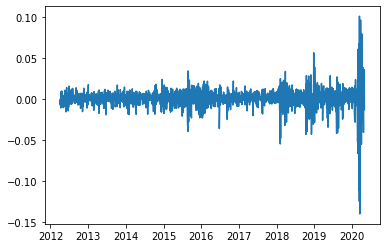

In [58]:
plot.plot(series_close_diff)

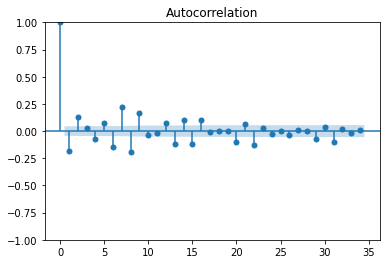

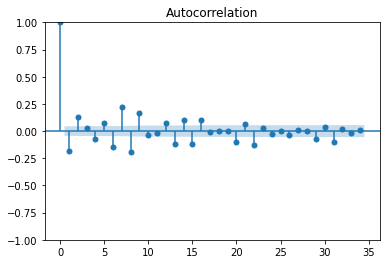

In [106]:
plot_acf(series_close_diff)

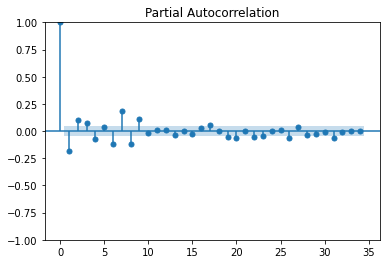

In [63]:
plot_pacf(series_close_diff)
plot.show()

In [59]:
# Compare AR(1), AR(7), AR(9), AR(31)

# plot.figure(figsize=(12,12))

# ar_orders = [1, 7, 9, 31]
# fitted_model_dict = {}

# for idx, ar_order in enumerate(ar_orders):
    
#     #create AR(p) model
#     ar_model = ARMA(series_close_diff, order=(ar_order,0))
#     ar_model_fit = ar_model.fit()
#     fitted_model_dict[ar_order] = ar_model_fit
#     plot.subplot(4,1,idx+1)
#     plot.plot(series_close_diff)
#     plot.plot(ar_model_fit.fittedvalues)
#     plot.title('AR(%s) Fit'%ar_order, fontsize=16)

# plt.tight_layout()